In [10]:
import matplotlib.pyplot as plt
import importlib
import bitmap_editor
importlib.reload(bitmap_editor)
import numpy as np

height = 20
width = 20
bitmap_matrix = np.zeros(shape=(height,width))
bitmapEditor = bitmap_editor.BitmapEditor(bitmap_matrix)

Canvas(height=200, width=200)

In [ ]:
import navier_stokes
importlib.reload(navier_stokes)

grid = np.flip(np.copy(bitmap_matrix), 0)

w = np.full(grid.shape + (2,), [0.0,0.0])

for j in range(3, 12):
    for i in range(5,15):
        w[(j,i)] = [0.1, 0]

cells = navier_stokes.cells(grid)
fluid_cells = [c for c in cells.flat if isinstance(c, navier_stokes.FluidCell)]
A = navier_stokes.projection_A(fluid_cells)
b = navier_stokes.projection_b(fluid_cells, w)

8
2.51660878286466e-10


/Users/vladimirmakaric/anaconda3/envs/ai/lib/python3.11/site-packages/pyamg/classical/classical.py:97: SparseEfficiencyWarning: Implicit conversion of A to CSR
  warn('Implicit conversion of A to CSR',


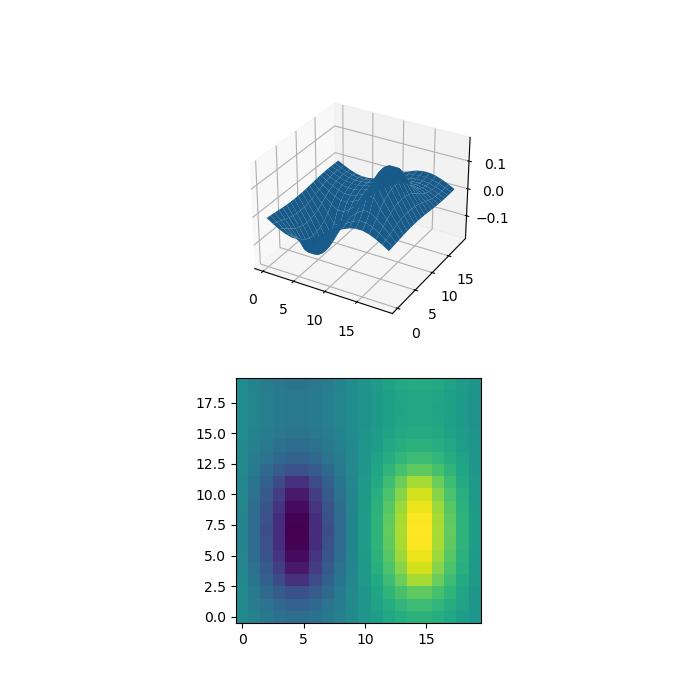

In [ ]:
%matplotlib widget
import pyamg

ml = pyamg.ruge_stuben_solver(A)  # Build the multigrid hierarchy
residuals = []
x = ml.solve(b, tol=1e-8, maxiter=100, residuals=residuals)
print(len(residuals))
print(residuals[-1])
# x = np.linalg.solve(A,b)


mesh = np.zeros(shape=(height,width))

avg = np.average(x)

for cell in cells.flat:
    if isinstance(cell, navier_stokes.ObstacleInteriorCell):
        mesh[cell.index] = avg
        continue
    if isinstance(cell, navier_stokes.FluidCell):
        mesh[cell.index] = x[cell.num]

for cell in cells.flat:
    if isinstance(cell, navier_stokes.BoundaryCell):
        w = np.array([1, 0])
        # g = (other_x*abs(nx) + other_y*abs(ny) + b)/(np.abs(nx + ny))
        an_x = np.abs(cell.normal[0])
        an_y = np.abs(cell.normal[1])
        mesh[cell.index] = np.dot(w, cell.normal)/(an_x + an_y)
        if cell.x_diff:
            mesh[cell.index] += mesh[cell.x_diff.fluid_cell.index]*an_x/(an_x + an_y)
        if cell.y_diff:
            mesh[cell.index] += mesh[cell.y_diff.fluid_cell.index]*an_y/(an_x + an_y)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(211, projection='3d')
ax2 = fig.add_subplot(212)
ax2.imshow(mesh, interpolation='none', origin='lower')
X, Y = np.meshgrid(np.arange(width), np.arange(height))
ax.plot_surface(X,Y,mesh) 
plt.show()

In [ ]:
a = np.array([0,0])
print(tuple(a))

(0, 0)


In [55]:
def read_matrix(filename):
    with open(filename) as f:
        return np.array([list(map(int, line.strip().split(","))) for line in f])

print(np.array(read_matrix('grids/triangle10x10.txt')))


[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 1 1 1 0 0 0]
 [0 0 0 1 1 1 1 0 0 0]
 [0 0 1 1 1 1 1 0 0 0]
 [0 0 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [9]:
gradP = np.zeros(shape=mesh.shape + (2,))

for cell in cells.flat:
    match cell:
        case navier_stokes.FluidCell(j=j, i=i):
            gradP[cell.index] = [
                (mesh[cell.right.index] - mesh[cell.left.index]) / 2,
                (mesh[cell.up.index] - mesh[cell.down.index]) / 2,
            ]
        case navier_stokes.BoundaryCell(j=j, i=i, x_diff=x_diff, y_diff=y_diff):
            if x_diff:
                gradP[cell.index][0] = (
                    mesh[x_diff.fluid_cell.index] - mesh[cell.index]
                ) * x_diff.dir
            if y_diff:
                gradP[cell.index][1] = (
                    mesh[y_diff.fluid_cell.index] - mesh[cell.index]
                ) * y_diff.dir

newW = w - gradP

for cell in cells.flat:
    if isinstance(cell, navier_stokes.ObstacleInteriorCell):
        newW[cell.index] = [0, 0]


[array([ 4., 13.]), array([ 4.08806528, 12.60380759]), array([ 4.18292386, 12.11076099]), array([ 4.27730393, 11.49718299]), array([ 4.66651298, 10.85931242]), array([ 5.88378   , 10.26022731]), array([7.19973253, 9.93512791]), array([8.53337688, 9.76831666]), array([9.90351394, 9.70593269]), array([11.27943482,  9.73087139]), array([12.62338902,  9.84786574])]


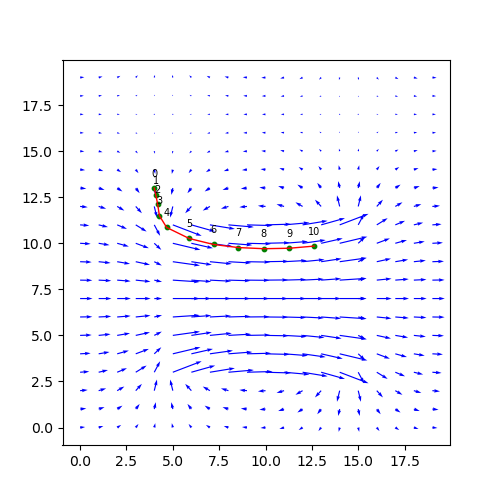

In [51]:
# plt.plot([0,L], [-D1/2,-D2/2], color="red", linewidth=3)
# plt.plot([0,0], [D1/2,-D1/2], color="red", linewidth=3)
# plt.plot([L,L], [D2/2,-D2/2], color="red", linewidth=3)



importlib.reload(navier_stokes)

fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, newW[:, :, 0], newW[:, :, 1], color="b")

steps = navier_stokes.streamline(pos=np.array([4,13],dtype=np.float64), dt=200, steps=10, vf=newW)
print(steps)
xysteps = np.array(steps).T
plt.plot(xysteps[0], xysteps[1], color="red", linewidth=1)

for i, point in enumerate(steps):
    plt.text(point[0], point[1] + 0.5, str(i), fontsize=7, ha='center', va='bottom')
    plt.scatter(point[0], point[1], color='green', s=10)  # s sets the marker size

# Add text above the point
# Adjust the y-value (here y + 0.2) to position the number above the point


# ax.quiver(X, Y, U,V, color="r")
plt.show()

In [3]:

gfh = np.zeros(shape=(10,10))

gfh[3:6,2:4] = 2
print(gfh)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
